# Amazon Food Reveiw Prediction

Data URL: https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

DataSet contains below features:  
**Id :** Row Id  
**ProductId :** Unique identifier for the product  
**UserId :** Unqiue identifier for the user  
**ProfileName :** Profile name of the user  
**HelpfulnessNumerator :** Number of users who found the review helpful  
**HelpfulnessDenominator :** Number of users who indicated whether they found the review helpful or not  
**Score :** Rating between 1 and 5  
**Time :** Timestamp for the review  
**Summary :** Brief summary of the review  
**Text :** Text of the review 

### Importing Necessary Libraries

In [37]:
# Generic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn - specific
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# NLP - specific
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load Data

Downloaded Original Dataset from URL : https://www.kaggle.com/snap/amazon-fine-food-reviews

### Uploading Original Dataset into google colab

In [2]:
from google.colab import files
uploaded = files.upload()

### Reading Data from uploaded csv file

In [0]:
data = pd.read_csv('/content/drive/My Drive/Study Materials/Amazon_Food_Review_DataSet.csv')

## Data Info

In [4]:
data.shape

(568454, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Cloning Data

Cloning data into another variable so not to change original dataset.

In [0]:
def clone_data(dataset):
  return dataset.copy(deep=True)

## Feature Engineering & Data Preprocessing

### Duplicate Records Deletion

In [0]:
def delete_duplicate_records(df, keys):
  
  # Check if any duplicate rows
  duplicate_reviews_count = df[df.duplicated(keys, keep='first') == True].shape[0]
  print('Number of Duplicate Reviews by a user for same product : ', duplicate_reviews_count)

  if duplicate_reviews_count > 0:
     #Deleting duplicate rows
     df.drop_duplicates(keys, keep='first', inplace=True)
  print('Duplicate Rows Deletion ... Completed')
  return df

### Unwanted Features Removal

In [0]:
def drop_features(df, features):
  if len(features) > 0:
    df.drop(features, axis=1, inplace=True)
  
  print('{} Features Deletion ... Completed'.format(len(features)))
  return df

### Missing Value Treatment

In [0]:
def drop_missing_records(df):
  df.dropna(axis=0,how='any', inplace=True)
  return df

### Feature Correlation

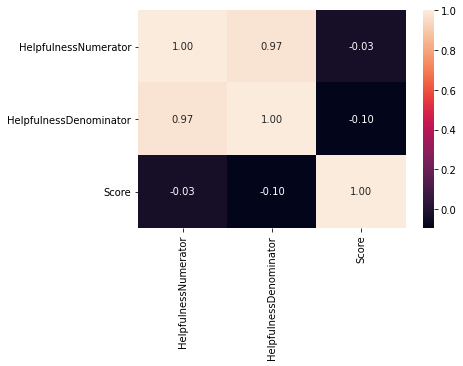

In [97]:
sns.heatmap(data=data_.corr(), annot=True, fmt='.2f', cbar=True)
plt.show()

### Feature Statistics

In [0]:
def show_feature_stat(df):
  return df.describe()

### Feature Value Mapping

In [0]:
def transform_values(df, feature, mapping):
  df[feature] = df[feature].map(mapping)
  return df

### Outlier Treatment

In [0]:
def treat_outliers(df, feature):
  print('Scatter Plot Visual.... \n')
  sns.scatterplot(data=df[feature])
  plt.show()

  #Percentile Method to handle Outlier
  percentile_99th = np.percentile(a=df[feature],q=99.05)
  print('99.05th Percentile Value for feature {} is {} '.format(feature, percentile_99th))

  outlier_count = df[feature][df[feature] > percentile_99th].count()
  print('There are {} outliers , value above 99th Percentile'.format(outlier_count))

  df[feature][df[feature] > percentile_99th] = percentile_99th
  print('Outliers treatment ... Completed')

  return df

### Feature Scaling

In [0]:
def feature_scale(df, features, scaler_type ='Standard'):
  if scaler_type == 'MinMax':
    scaler = MinMaxScaler()
  elif scaler_type == 'Normalizer':
    scaler = Normalizer()
  else:
    scaler = StandardScaler()

  ft_array = df[features].values
  scaled_values = scaler.fit_transform(ft_array.reshape(-1,1))
  df.loc[:,features] = scaled_values

  return df, scaler

### Text Data Preprocessing (NLTK)

#### Preprocessing

In [0]:
def preprocess_text_data(df, text_feature):

  # Replacing Non Aplhabetical Characters
  cleaned_text = df[text_feature].str.replace('[^A-Za-z\s]', '') 

  # To lowercase
  # Stopword Removal
  # Porter Stemming
  # Shorter length word removal
  stop_words = stopwords.words('english')
  stemer = PorterStemmer()
  cleaned_text = [' '.join([stemer.stem(tokens.lower()) for tokens in review_tokens.split(' ') if len(tokens) > 2 and tokens.lower() not in stop_words]) for review_tokens in cleaned_text]

  return cleaned_text

#### Feature Extraction (Word Embedding)

In [0]:
def extract_features(text_array, max_features = 1000, max_df = 0.9):

  vectorizer = TfidfVectorizer(max_features=max_features, max_df=max_df)
  tf_idf_matrix = vectorizer.fit_transform(text_array)
  
  return tf_idf_matrix, vectorizer

## Model Building

### Features Seperation

In [0]:
def get_features_seperated(df, target, features=None):
  if len(features) > 0:
    X = df[features]
  else:
    X = df.drop(target, axis=1)

  Y = df[target]

  return X, Y

### Train and Test Data Split

In [0]:
def get_train_test_data(X, Y, test_size=0.2):
  X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y ,test_size=test_size, random_state=42)
  return X_Train, X_Test, Y_Train, Y_Test

### Train Model

#### SGD Classifier Model

In [0]:
def train_sgd_clf(X_Train, Y_Train, loss='log'):

  clf = SGDClassifier(loss=loss, class_weight='balanced')
  clf.fit(X_Train, Y_Train)

  return clf

## Model Testing

In [0]:
def test_model(model, X_Test, Y_Actual):

  Y_Pred = model.predict(X_Test)

  conf_matrx = confusion_matrix(Y_Actual,Y_Pred)
  accuracy = accuracy_score(Y_Actual,Y_Pred)
  
  return pd.DataFrame(Y_Pred, columns=['Predicted_Score']), conf_matrx, accuracy

## Trigger Point

>1. Cloning Data
2. Deleting Duplicate Records (Key = ProductId and UserId)
3. Droping Unwanted Features (Id, UserId, ProductId, ProfileName and Time)

In [19]:
data_ = clone_data(data)
data_ = delete_duplicate_records(data_, keys=['ProductId','UserId'])
data_ = drop_features(data_, features=['Id','UserId','ProductId','ProfileName','Time'])

Number of Duplicate Reviews by a user for same product :  7650
Duplicate Rows Deletion ... Completed
5 Features Deletion ... Completed


>4. Check for Missing Values
5. Delting Records with Missing Value(Because only 27 out of 5 lakh values are missing)

In [20]:
print('Missing Value Counts Per Feature : \n\n',data_.isnull().sum())
data_ = drop_missing_records(data_)

Missing Value Counts Per Feature : 

 HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Summary                   27
Text                       0
dtype: int64


> 6. Check for corelation between features 'HelpfulnessDenominator' and 'HelpfulnessNumerator'
7. Drop one of the feature if r> 0.95


In [21]:
show_feature_stat(data_)

,HelpfulnessNumerator,HelpfulnessDenominator,Score
count,560777.000000,560777.000000,560777.000000
mean,1.743156,2.224328,4.183178
std,7.666544,8.314773,1.310479
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,4.000000
50%,0.000000,1.000000,5.000000
75%,2.000000,2.000000,5.000000
max,866.000000,923.000000,5.000000


We can understand from above statistics that feature 'HelpfulnessNumerator' is better interms of mean, max, std values. Hence we would drop 'HelpfulnessDenominator'.

In [22]:
data_ = drop_features(data_, features=['HelpfulnessDenominator'])

1 Features Deletion ... Completed


>8. Check for Outliers in feature 'HelpfulnessNumerator'
9. Replace outliers with 99th Percentile value

Scatter Plot Visual.... 



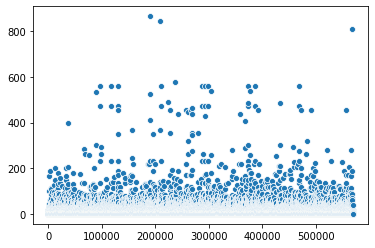

99.05th Percentile Value for feature HelpfulnessNumerator is 20.0 
There are 5090 outliers , value above 99th Percentile
Outliers treatment ... Completed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [23]:
data_ = treat_outliers(data_, feature='HelpfulnessNumerator')

>10. Changing Score numerical values to categorical. 

In [0]:
mapping = {1:'Negetive', 2:'Negetive', 3:'Neutral', 4:'Positive', 5:'Positive' }
data_ = transform_values(data_, 'Score', mapping)

>Model Building 
 11. Taking Random sample of size 80% from original dataset. 
 12. Sperate out features and target variable
 13. Split Dataset into Training and Testing with a test size of 30%

In [25]:
sampled_data = data_.sample(frac=0.8, random_state=11)
print('Sampled Data Size ', sampled_data.shape)

Sampled Data Size  (448622, 4)


In [28]:
features, target = get_features_seperated(sampled_data, target='Score' , features=['HelpfulnessNumerator','Summary'])
train_features, test_features, train_target, test_target = get_train_test_data(features, target, test_size=0.3)
print('Shape of Trainig Features , ',train_features.shape)
print('Shape of Testing Features , ',test_features.shape)
print('Shape of Training Target ,',train_target.shape)
print('Shape of Testing Target ,',test_target.shape)

Shape of Trainig Features ,  (314035, 2)
Shape of Testing Features ,  (134587, 2)
Shape of Training Target , (314035,)
Shape of Testing Target , (134587,)


>14. Feature Scaling for 'HelpfulnessNumerator' - (MinMaxScaling)

In [29]:
train_features, scaler = feature_scale(train_features, 'HelpfulnessNumerator', scaler_type ='MinMax')
train_features.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,HelpfulnessNumerator,Summary
189373,0.1,Gives a Good Hint of Coconut to Food
96389,0.1,Almost perfect oil.
239295,0.0,I love this!!!
380388,0.1,Arrived moldy!
199702,0.0,horrible but seller stands by his product


>14. Preprocessing Feature 'Summary'
15. Extract features from preprocessed text. (Keeping max 5000 features, dropping features which occured more than 80% of time)

In [0]:
processed_summary = preprocess_text_data(train_features, 'Summary')
feature_matrix, vectorizer = extract_features(processed_summary, max_features=5000, max_df=0.8)

>16. Changing data type of feature matrix from 'float64' to 'float32' inorder to consume less memory

In [0]:
feature_matrix = feature_matrix.astype('float32')

In [33]:
feature_matrix.shape

(314035, 5000)

Now we will combine this matrix data with 'train_features' and then we will pass this combined data as an input to our classifier.

In [34]:
#Reseting Index
train_features.reset_index(inplace=True, drop=True)

# Removing the unwanted 'Summary' feature because already we extractde fetaures from 'Summary'
train_features.drop('Summary',axis=1,inplace=True)

# Chaning 'train_features' dtype to 'float32'
train_features = train_features.astype('float32', copy=True)

# Concatenating feature_matrix with train_features to get final features
train_features = pd.concat([train_features,pd.DataFrame(feature_matrix.toarray(),dtype='float32')],axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


>17. Lets Train SGD Classifer model. Loss = 'log' indicates it would train a LogisticRegression Model with SGD training approach.

In [0]:
model = train_sgd_clf(X_Train=train_features.values, Y_Train=train_target.values, loss='log')

Training SGD Classifier with data input of shape (314035, 5000) is completed. Now we will test our model.

Before testing our test data also has to be preprocessed likewise trainind data.

In [41]:
# Scaling 'HelpfulnessNumerator'
test_features['HelpfulnessNumerator'] = scaler.transform(test_features.HelpfulnessNumerator.values.reshape(-1,1))

# Preprocessing Summary
test_processed_summary = preprocess_text_data(test_features, 'Summary')

# Extracting Features
test_feature_matrix = vectorizer.transform(test_processed_summary)
test_feature_matrix = test_feature_matrix.astype('float32')

# preparing test_features
test_features.reset_index(inplace=True, drop=True)
test_features.drop('Summary',axis=1,inplace=True)
test_features = test_features.astype('float32', copy=True)

# Combining test_features with test_feature_matrix
test_features = np.concatenate([test_features,test_feature_matrix.toarray()],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Test Data has been preprocessed using same 'scaler' and 'vectorizer' object as used to preprocess training dataset. Now we will test model by passing 'model' object and final test data.

Confusion Matrix 



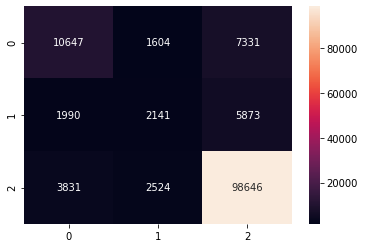

Accuracy Score ,  0.8279700119625224


In [47]:
predicted_vals, conf_matrix, accuracy = test_model(model=model, X_Test= test_features, Y_Actual= test_target )

print('Confusion Matrix \n')
sns.heatmap(data=conf_matrix, fmt='d', annot=True)
plt.show()

print('Accuracy Score , ', accuracy)

We have achieved an accurac score of 82%. We can further tune our SGDClassifier for different hyperparameters, also we can train our models with more number of features (> 5000) to get better accuracy